# Usage consistensy analysis
 Goal: 
 Identify patterns of consistent gym use and seasonal trends, such as “New Year’s resolution” drop-offs, which can inform retention strategies.
	• Tasks:
		○ Analyze check-in data over time to detect frequency trends by month, segmented by age and gender.
		○ Use frequent itemset mining (A-Priori Algorithm) to reveal common patterns in check-in behaviors, like peak times or recurring visits on specific days.
		○ Identify which demographics show high retention versus early drop-off after certain times of the year.
	• Course Topic Covered: Frequent Itemsets - week 5

### 1. Analyzing Check-In Data Over Time (Trends by Month, Age, and Gender)

#### 1.1 Load and explore data 

In [12]:
import pandas as pd 
import matplotlib.pyplot as plt

# Load data
checkin_data = pd.read_csv("../data/_raw/checkin_checkout_history_updated.csv", parse_dates= ['checkin_time', 'checkout_time'])
user_data = pd.read_csv("../data/_raw/users_data.csv")

# Merge user data and checkin data and drop irrelevant columns 
data = user_data.merge(checkin_data, on="user_id", how="left")
data = data.drop(columns= ["first_name", "last_name","birthdate", "calories_burned"])

# Extract month from checkin time 
data['month'] = data['checkin_time'].dt.month 

bins = [0, 18, 25, 35, 50, 65, 100]
labels = ['<18', '18-25', '26-35', '36-50', '51-65', '65+']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels, right=False)

# Group data by month, gender, and age group
monthly_trends = data.groupby(['month', 'gender', 'age_group']).size().reset_index(name='check_in_count')

print(monthly_trends.head(10))



   month  gender age_group  check_in_count
0      1  Female       <18               0
1      1  Female     18-25            2030
2      1  Female     26-35            3092
3      1  Female     36-50            4330
4      1  Female     51-65            4595
5      1  Female       65+               0
6      1    Male       <18               0
7      1    Male     18-25            2284
8      1    Male     26-35            3146
9      1    Male     36-50            5073


/var/folders/5_/qzm0v30543z41kg2f8py6jqh0000gn/T/ipykernel_36341/965725320.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_trends = data.groupby(['month', 'gender', 'age_group']).size().reset_index(name='check_in_count')


#### 1.2 Visualize data

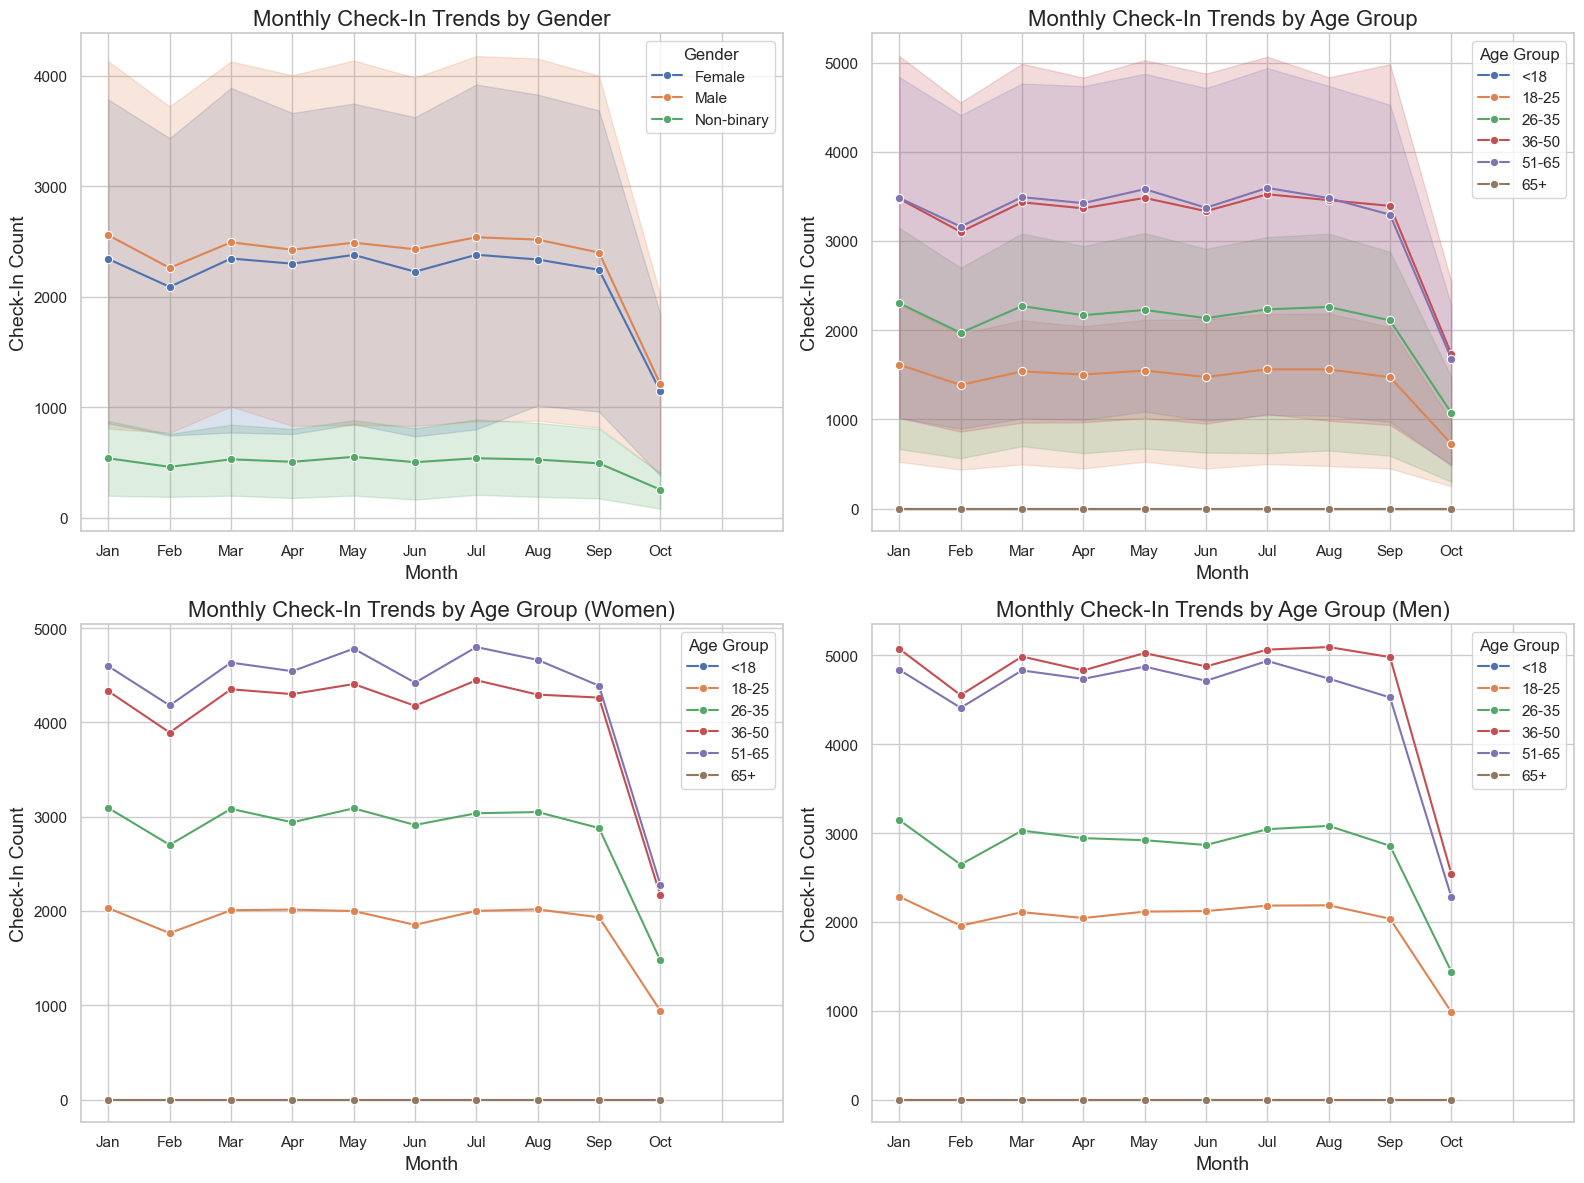

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style for the plots
sns.set(style="whitegrid")

# Create a figure with 2 rows and 2 columns (4 subplots in total)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Monthly Check-In Trends by Gender
sns.lineplot(data=monthly_trends, x='month', y='check_in_count', hue='gender', marker='o', ax=axes[0, 0])
axes[0, 0].set_title('Monthly Check-In Trends by Gender', fontsize=16)
axes[0, 0].set_xlabel('Month', fontsize=14)
axes[0, 0].set_ylabel('Check-In Count', fontsize=14)
axes[0, 0].set_xticks(range(1, 13))
axes[0, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','',''])
axes[0, 0].legend(title='Gender')

# Plot 2: Monthly Check-In Trends by Age Group
sns.lineplot(data=monthly_trends, x='month', y='check_in_count', hue='age_group', marker='o', ax=axes[0, 1])
axes[0, 1].set_title('Monthly Check-In Trends by Age Group', fontsize=16)
axes[0, 1].set_xlabel('Month', fontsize=14)
axes[0, 1].set_ylabel('Check-In Count', fontsize=14)
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','',''])
axes[0, 1].legend(title='Age Group')

# Plot 3: Monthly Check-in data for women by Age group
women_data = monthly_trends[monthly_trends['gender'] == 'Female']
sns.lineplot(data=women_data, x='month', y='check_in_count', hue='age_group', marker='o', ax=axes[1, 0])
axes[1, 0].set_title('Monthly Check-In Trends by Age Group (Women)', fontsize=16)
axes[1, 0].set_xlabel('Month', fontsize=14)
axes[1, 0].set_ylabel('Check-In Count', fontsize=14)
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','',''])
axes[1, 0].legend(title='Age Group')

# Plot 4: Monthly Check-in data for men by Age group
men_data = monthly_trends[monthly_trends['gender'] == 'Male']
sns.lineplot(data=men_data, x='month', y='check_in_count', hue='age_group', marker='o', ax=axes[1, 1])
axes[1, 1].set_title('Monthly Check-In Trends by Age Group (Men)', fontsize=16)
axes[1, 1].set_xlabel('Month', fontsize=14)
axes[1, 1].set_ylabel('Check-In Count', fontsize=14)
axes[1, 1].set_xticks(range(1, 13))
axes[1, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','',''])
axes[1, 1].legend(title='Age Group')


plt.tight_layout()
plt.show()


### 2. Frequent itemset mining: Frequent patterns (Cross-combination of checkin time and day of the week)

#### 2.1 Loading and preprocessing data 

In [2]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori 

# Load and preprocess data
data = pd.read_csv("../data/checkins.csv", parse_dates=['checkin_time'])

# Extract day of week and time of day
data['day_of_week'] = data['checkin_time'].dt.day_name()
data['time_of_day'] = pd.cut(
    data['checkin_time'].dt.hour,
    bins=[0, 12, 18, 24],
    labels=['Morning', 'Afternoon', 'Evening'],
    right=False
)

# Group check-ins into user-level transactions
transactions = data.groupby('user_id', group_keys=False).apply(
    lambda x: list(x['day_of_week'] + " " + x['time_of_day'].astype(str))
).tolist()

print(f"Number of transactions: {len(transactions)}")
print(f"Number of unique items: {len(set(item for sublist in transactions for item in sublist))}")


Number of transactions: 5000
Number of unique items: 21


/var/folders/5_/qzm0v30543z41kg2f8py6jqh0000gn/T/ipykernel_92096/3448360018.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  transactions = data.groupby('user_id', group_keys=False).apply(


#### 2.2 Applying the A-priori algorithm 


In [ ]:
# Convert transactions to one-hot encoded DataFrame
encoder = TransactionEncoder()
encoded_data = encoder.fit(transactions).transform(transactions)
df = pd.DataFrame(encoded_data, columns=encoder.columns_)

# Find frequent itemsets
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True, max_len =1)

# Display results
print("Frequent Itemsets:")
print(frequent_itemsets)

Frequent Itemsets:
    support               itemsets
0    0.9630     (Friday Afternoon)
1    0.8110       (Friday Evening)
2    0.9672       (Friday Morning)
3    0.9708     (Monday Afternoon)
4    0.8112       (Monday Evening)
5    0.9706       (Monday Morning)
6    0.9712   (Saturday Afternoon)
7    0.8156     (Saturday Evening)
8    0.9666     (Saturday Morning)
9    0.9722     (Sunday Afternoon)
10   0.8318       (Sunday Evening)
11   0.9738       (Sunday Morning)
12   0.9694   (Thursday Afternoon)
13   0.8162     (Thursday Evening)
14   0.9650     (Thursday Morning)
15   0.9648    (Tuesday Afternoon)
16   0.8196      (Tuesday Evening)
17   0.9708      (Tuesday Morning)
18   0.9674  (Wednesday Afternoon)
19   0.8190    (Wednesday Evening)
20   0.9688    (Wednesday Morning)


#### 2.3 Visualize results

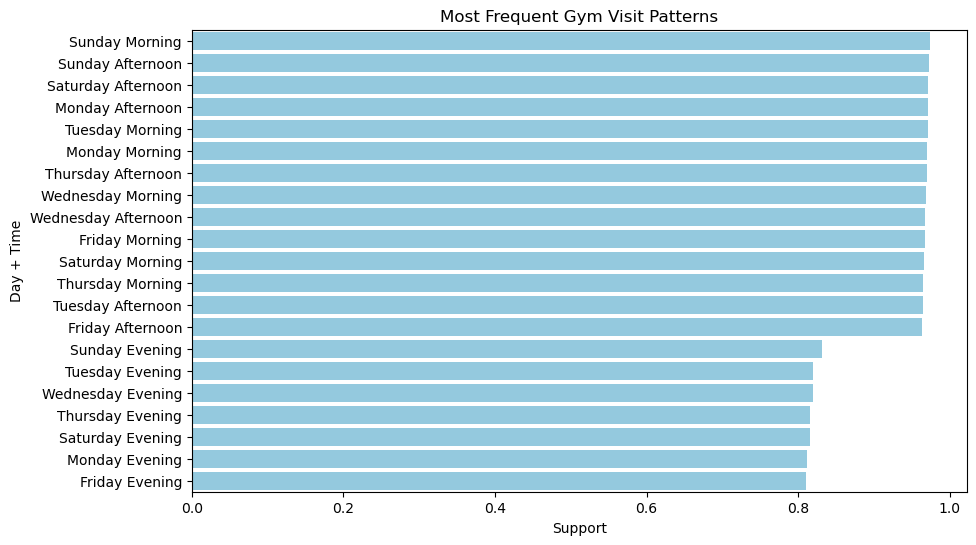

/var/folders/5_/qzm0v30543z41kg2f8py6jqh0000gn/T/ipykernel_92096/2644675949.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=time_of_day_counts.index, y=time_of_day_counts.values, palette="Blues_d")


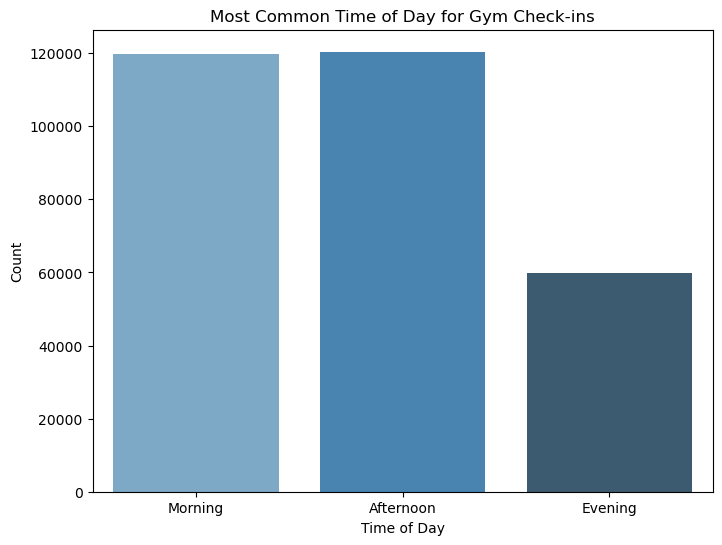

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort itemsets by support
top_patterns = frequent_itemsets.sort_values(by="support", ascending=False)
top_patterns['itemsets'] = top_patterns['itemsets'].apply(lambda x: ', '.join(list(x)))

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x="support", y=top_patterns["itemsets"].astype(str), data=top_patterns, color="skyblue")
plt.title("Most Frequent Gym Visit Patterns")
plt.xlabel("Support")
plt.ylabel("Day + Time")
plt.show()

time_of_day_counts = data['time_of_day'].value_counts()

# Plot the results
plt.figure(figsize=(8, 6))
sns.barplot(x=time_of_day_counts.index, y=time_of_day_counts.values, palette="Blues_d")
plt.title("Most Common Time of Day for Gym Check-ins")
plt.xlabel("Time of Day")
plt.ylabel("Count")
plt.show()
